In [ ]:
import numpy as np

In [ ]:
class ReplayMemory:
    def __init__(self, mem_size, states_dim, actions_dim):
        self.mem_size = mem_size
        self.no_total_transitions = 0
        self.states = np.zeros((self.mem_size, states_dim))
        self.new_states = np.zeros((self.mem_size, states_dim))
        self.actions = np.zeros((self.mem_size, actions_dim))
        self.rewards = np.zeros(self.mem_size)
        #self.dones = np.zeros(self.mem_size, dtype=np.bool8)
    
    
    def store_transition(self, state, action, reward, new_state):
    #def store_transition(self, state, action, reward, new_state, done):
        idx = self.no_total_transitions % self.mem_size
        
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.new_states[idx] = new_state
        #self.dones[idx] = done
        
        self.no_total_transitions += 1
    
    
    def sample(self, batch_size):
        effective_mem_size = min(self.mem_size, self.no_total_transitions)
        
        batch_idxs = np.random.choice(
            effective_mem_size, batch_size, replace=False
        )
        
        states = self.states[batch_idxs]
        actions = self.actions[batch_idxs]
        rewards = self.rewards[batch_idxs]
        new_states = self.new_states[batch_idxs]
        #dones = self.dones[batch_idxs]
        
        return states, actions, rewards, new_states
        #return states, actions, rewards, new_states, dones
        

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer

In [ ]:
class ActorNN(keras.Model):
    def __init__(self, states_dim, acotr_max_action_val, hidden_layers):
        super(ActorNN, self).__init__()
        self.acotr_max_action_val = acotr_max_action_val
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(states_dim,)))
        for hidden_layer in hidden_layers:
            self.model.add(Dense(hidden_layer, activation='relu'))
        self.model.add(Dense(len(acotr_max_action_val), activation='tanh'))
    
    def call(self, states):
        a = self.acotr_max_action_val * self.model(states)
        return a
        

In [ ]:
class CriticNN(keras.Model):
    def __init__(self, states_dim, actions_dim, hidden_layers):
        super(CriticNN, self).__init__()
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(states_dim + actions_dim,)))
        for hidden_layer in hidden_layers:
            self.model.add(Dense(hidden_layer, activation='relu'))
        self.model.add(Dense(1, activation=None))
    
    def call(self, states, actions):
        q = self.model(tf.concat([states, actions], axis=1))
        return q
        

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [ ]:
class Agent:
    def __init__(self, states_dim, acotr_max_action_val,
                 actor_hidden_layers=[400,300],
                 critic_hidden_layers=[400,300],
                 actor_lr=0.001, critic_lr=0.002, gamma=0.99,
                 tau=0.005, batch_size=64, mem_size=1000000,
                 noise_std=0.1):
        
        # acotr_max_action_val: 1-dimensional tf.Constant (actions_dim,)
        self.acotr_max_action_val = acotr_max_action_val
        self.gamma = gamma
        self.tau = tau
        actions_dim = len(acotr_max_action_val)
        self.batch_size = batch_size
        
        self.replay_memory = ReplayMemory(mem_size, states_dim, actions_dim)
        
        self.actor = ActorNN(
            states_dim, acotr_max_action_val, actor_hidden_layers
        )
        self.target_actor = ActorNN(
            states_dim, acotr_max_action_val, actor_hidden_layers
        )
        self.critic = CriticNN(
            states_dim, actions_dim, critic_hidden_layers
        )
        self.target_critic = CriticNN(
            states_dim, actions_dim, critic_hidden_layers
        )
        
        self.actor.compile(
            optimizer=Adam(learning_rate=actor_lr)
        )
        self.target_actor.compile(
            optimizer=Adam(learning_rate=actor_lr)
        )
        self.critic.compile(
            optimizer=Adam(learning_rate=critic_lr)
        )
        self.target_critic.compile(
            optimizer=Adam(learning_rate=critic_lr)
        )
        
        
        self.update_target_nn(self.actor, self.target_actor, 1)
        self.update_target_nn(self.critic, self.target_critic, 1)
    
    
    @staticmethod
    def update_target_nn(nn, target_nn, tau):
        target_weights_list = []
        for i, w in enumerate(nn.weights):
            target_weights_list.append((tau * w) + ((1 - tau) * target_nn.weights[i]))
        target_nn.set_weights(target_weights_list)
    
    
    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation])
        action = self.actor(state)
        if not evaluate:
            action += tf.random.normal(
                shape=action.shape, mean=0.0, stddev=0.1
            )
            action = tf.clip_by_value(
                action, -self.acotr_max_action_val,
                self.acotr_max_action_val
            )
        return action[0]
    
    
    def learn(self):
        if self.replay_memory.no_total_transitions < self.batch_size:
            # Not enough collected data to train
            return None
        
        states, actions, rewards, new_states =\
        self.replay_memory.sample(self.batch_size)
        #states, actions, rewards, new_states, dones =\
        #self.replay_memory.sample(self.batch_size)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_states, dtype=tf.float32)
        
        
        # train critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(new_states)
            target_critic_vals = tf.squeeze(
                self.target_critic(new_states, target_actions), 1
            )
            
            ground_truth = rewards + (self.gamma * target_critic_vals)
            # if current state is last ===> consider only immediate reward
            #ground_truth = rewards + (self.gamma * target_critic_vals * (1-dones))
            
            critic_vals = tf.squeeze(
                self.critic(states, actions), 1
            )
            
            critic_loss = keras.losses.MSE(ground_truth, critic_vals)
        
        # gradient computed to minimize critic_loss
        critic_gradient = tape.gradient(
            critic_loss, self.critic.trainable_variables
        )
        
        self.critic.optimizer.apply_gradients(
            zip(critic_gradient, self.critic.trainable_variables)
        )
        
        
        # train actor
        with tf.GradientTape() as tape:
            # different from previous sample actions
            actions = self.actor(states)
            critic_vals = self.critic(states, actions)
            # gradient computed to maximize mean(critic_vals)
            actor_loss = tf.math.reduce_mean(-critic_vals)
        
        actor_gradient = tape.gradient(
            actor_loss, self.actor.trainable_variables
        )
        
        self.actor.optimizer.apply_gradients(
            zip(actor_gradient, self.actor.trainable_variables)
        )
        
        self.update_target_nn(self.actor, self.target_actor, self.tau)
        self.update_target_nn(self.critic, self.target_critic, self.tau)
    
    

In [ ]:
"""
agent = Agent(3, tf.constant([2.]), actor_hidden_layers=[2,3],
              critic_hidden_layers=[2,3])

print(agent.actor.weights)
print('\n====================================================\n')
print(agent.target_actor.weights)
"""

In [ ]:
import gym
import numpy as np

In [ ]:
if __name__ == '__main__':
    env = gym.make('Pendulum-v1')
    states_dim = env.observation_space.shape[0]
    acotr_max_action_val = tf.convert_to_tensor(env.action_space.high)
    agent = Agent(states_dim, acotr_max_action_val)
    n_games = 200
    steps_per_game = 1000
    
    score_history = []
    evaluate = False
    
    for g in range(n_games):
        print(f'game: {g}')
        observation = env.reset()[0]
        #done = False
        game_total_score = 0
        for t in range(steps_per_game):
        #while not done:
            action = agent.choose_action(observation, evaluate)
            action = np.array(action)
            #new_observation, reward, done, _, _ = env.step(action)
            new_observation, reward, *_ = env.step(action)
            game_total_score += reward
            #agent.replay_memory.store_transition(
            #    observation, action, reward, new_observation, done
            #)
            agent.replay_memory.store_transition(
                observation, action, reward, new_observation
            )
            agent.learn()
            observation = new_observation
        
        score_history.append(game_total_score)
    
    with open("score_history.txt", "w") as f:
        for s in score_history:
            f.write(str(s) +"\n")
    

## Saving Figure

<Figure size 432x288 with 0 Axes>

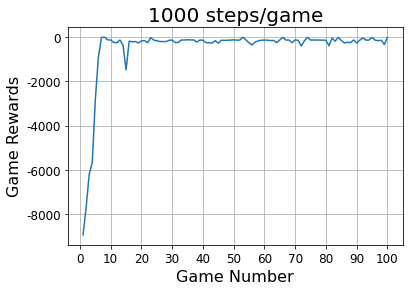

In [4]:
import matplotlib.pyplot as plt


plt.tight_layout()
fig, ax = plt.subplots()

# loading 100 records only
truncated_score_history = []
with open('score_history.txt', 'r') as f:
    for l in range(100):
        truncated_score_history.append(float(f.readline()))

ax.plot([g+1 for g in range(len(truncated_score_history))], truncated_score_history)

ax.set_title('1000 steps/game', fontsize=20)

ax.set_xticks(
    [10*i for i in range(11)], labels=[10*i for i in range(11)],
    fontsize=12
)
ax.set_yticks(
    [-2000*i for i in range(4,-1,-1)], labels=[-2000*i for i in range(4,-1,-1)],
    fontsize=12
)

ax.set_xlabel('Game Number', fontsize=16)
ax.set_ylabel('Game Rewards', fontsize=16)
ax.grid()
fig.savefig('learning.pdf', bbox_inches = 'tight')